In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, 
    average_precision_score, confusion_matrix, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay, roc_curve, precision_recall_curve
)

# Create reports directory if it doesn't exist
os.makedirs('../reports', exist_ok=True)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Load Data and Models

In [17]:
# Load Data (same split as training)
df = pd.read_csv("../data/processed/train_final.csv")

drop_cols = ["PotentialFraud", "Provider"]
X = df.drop(columns=drop_cols)
y = df["PotentialFraud"].astype(int)

# IMPORTANT: Use same random_state as 02_modeling.ipynb
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")
print(f"Fraud rate - Train: {y_train.mean():.2%}, Val: {y_val.mean():.2%}, Test: {y_test.mean():.2%}")

Train: 4328, Val: 541, Test: 541
Fraud rate - Train: 9.36%, Val: 9.43%, Test: 9.24%


In [18]:
# Load Saved Models
models = {}
thresholds = {}

try:
    models['Logistic Regression'] = joblib.load('../models/logistic_regression_cal.joblib')
    models['Random Forest'] = joblib.load('../models/random_forest_cal.joblib')
    models['Gradient Boosting'] = joblib.load('../models/gradient_boosting_cal.joblib')
    models['XGBoost'] = joblib.load('../models/xgboost_cal.joblib')
    thresholds = joblib.load('../models/thresholds.joblib')
    print("✅ All models loaded successfully!")
    for name in models:
        print(f"  - {name}: threshold = {thresholds.get(name, 0.5):.4f}")
except FileNotFoundError as e:
    print("❌ Models not found. Please run 02_modeling.ipynb first and save models.")
    print(f"Error: {e}")

✅ All models loaded successfully!
  - Logistic Regression: threshold = 0.3382
  - Random Forest: threshold = 0.2014
  - Gradient Boosting: threshold = 0.4757
  - XGBoost: threshold = 0.5218


In [19]:
# Generate Predictions for All Models
predictions = {}

for name, model in models.items():
    probs = model.predict_proba(X_test)[:, 1]
    thresh = thresholds.get(name, 0.5)
    preds = (probs >= thresh).astype(int)
    predictions[name] = {
        'probs': probs,
        'preds': preds,
        'threshold': thresh
    }
    print(f"{name}: {preds.sum()} fraud predictions ({preds.mean():.1%})")

Logistic Regression: 155 fraud predictions (28.7%)
Random Forest: 88 fraud predictions (16.3%)
Gradient Boosting: 115 fraud predictions (21.3%)
XGBoost: 103 fraud predictions (19.0%)


## 2. ROC Curve Comparison

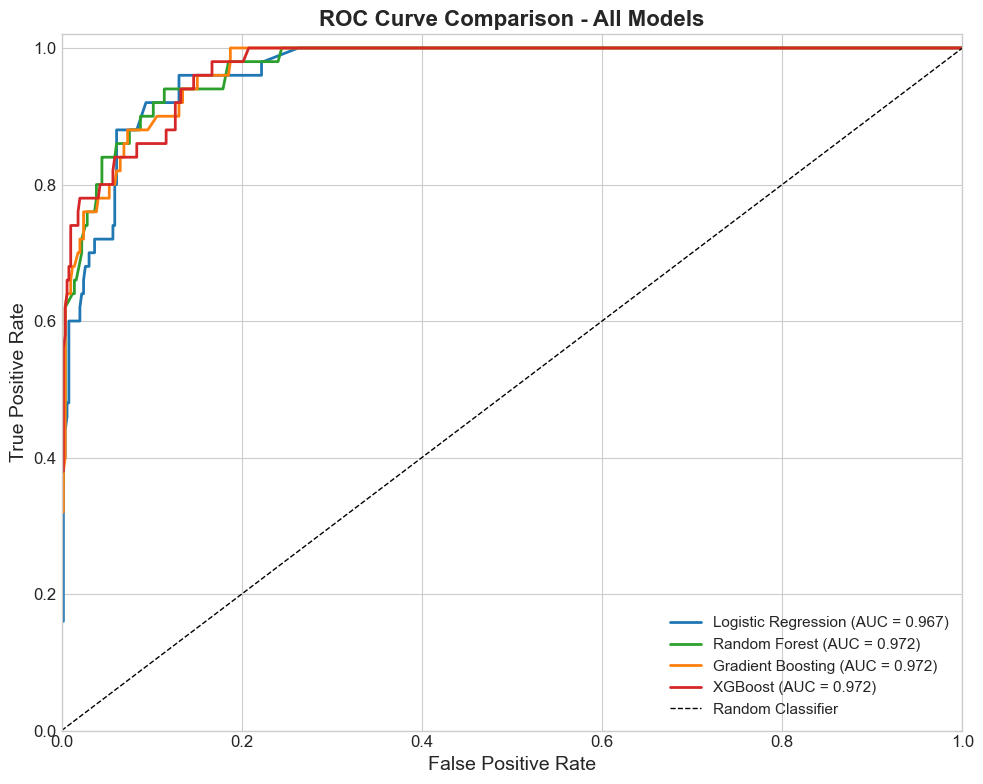

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

for (name, model), color in zip(models.items(), colors):
    probs = predictions[name]['probs']
    fpr, tpr, _ = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    ax.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', color=color, linewidth=2)

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('ROC Curve Comparison - All Models', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.02])
plt.tight_layout()
plt.savefig('../reports/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Precision-Recall Curve Comparison

Critical for imbalanced fraud detection - shows trade-off between catching fraud and false alarms.

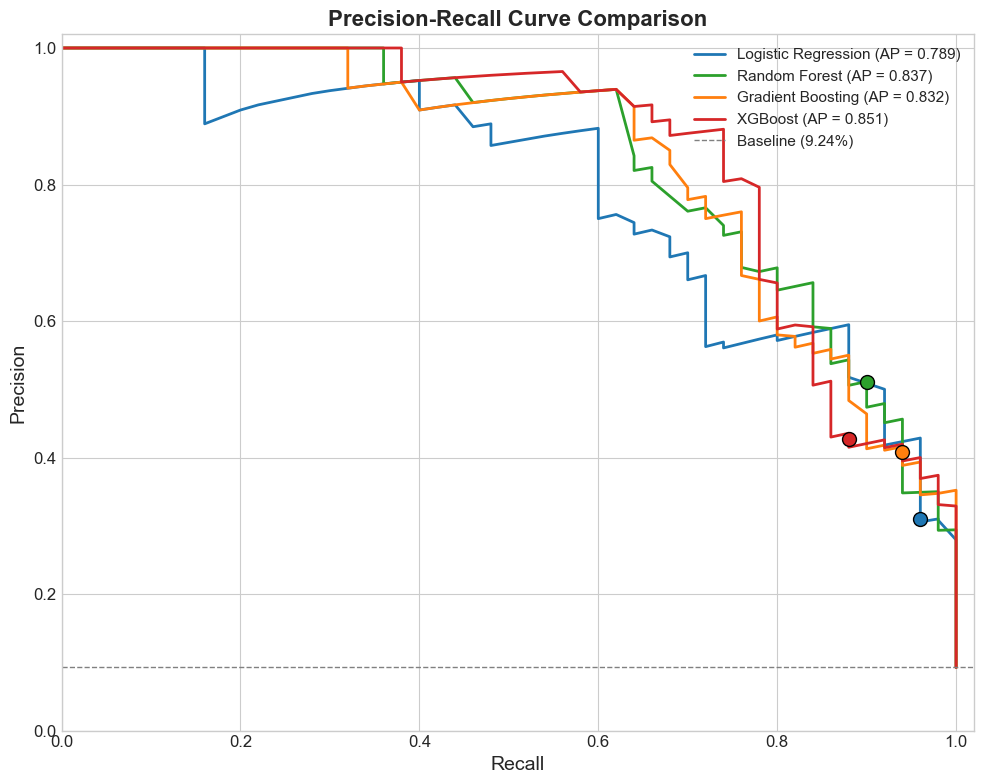

In [21]:
fig, ax = plt.subplots(figsize=(10, 8))

for (name, model), color in zip(models.items(), colors):
    probs = predictions[name]['probs']
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    ax.plot(recall, precision, label=f'{name} (AP = {ap:.3f})', color=color, linewidth=2)
    
    # Mark the operating threshold point
    thresh = predictions[name]['threshold']
    pred_at_thresh = (probs >= thresh).astype(int)
    p = precision_score(y_test, pred_at_thresh)
    r = recall_score(y_test, pred_at_thresh)
    ax.scatter([r], [p], color=color, s=100, zorder=5, edgecolor='black')

# Baseline (random classifier)
baseline = y_test.mean()
ax.axhline(y=baseline, color='gray', linestyle='--', label=f'Baseline ({baseline:.2%})', linewidth=1)

ax.set_xlabel('Recall', fontsize=14)
ax.set_ylabel('Precision', fontsize=14)
ax.set_title('Precision-Recall Curve Comparison', fontsize=16, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.set_xlim([0, 1.02])
ax.set_ylim([0, 1.02])
plt.tight_layout()
plt.savefig('../reports/precision_recall_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Confusion Matrices

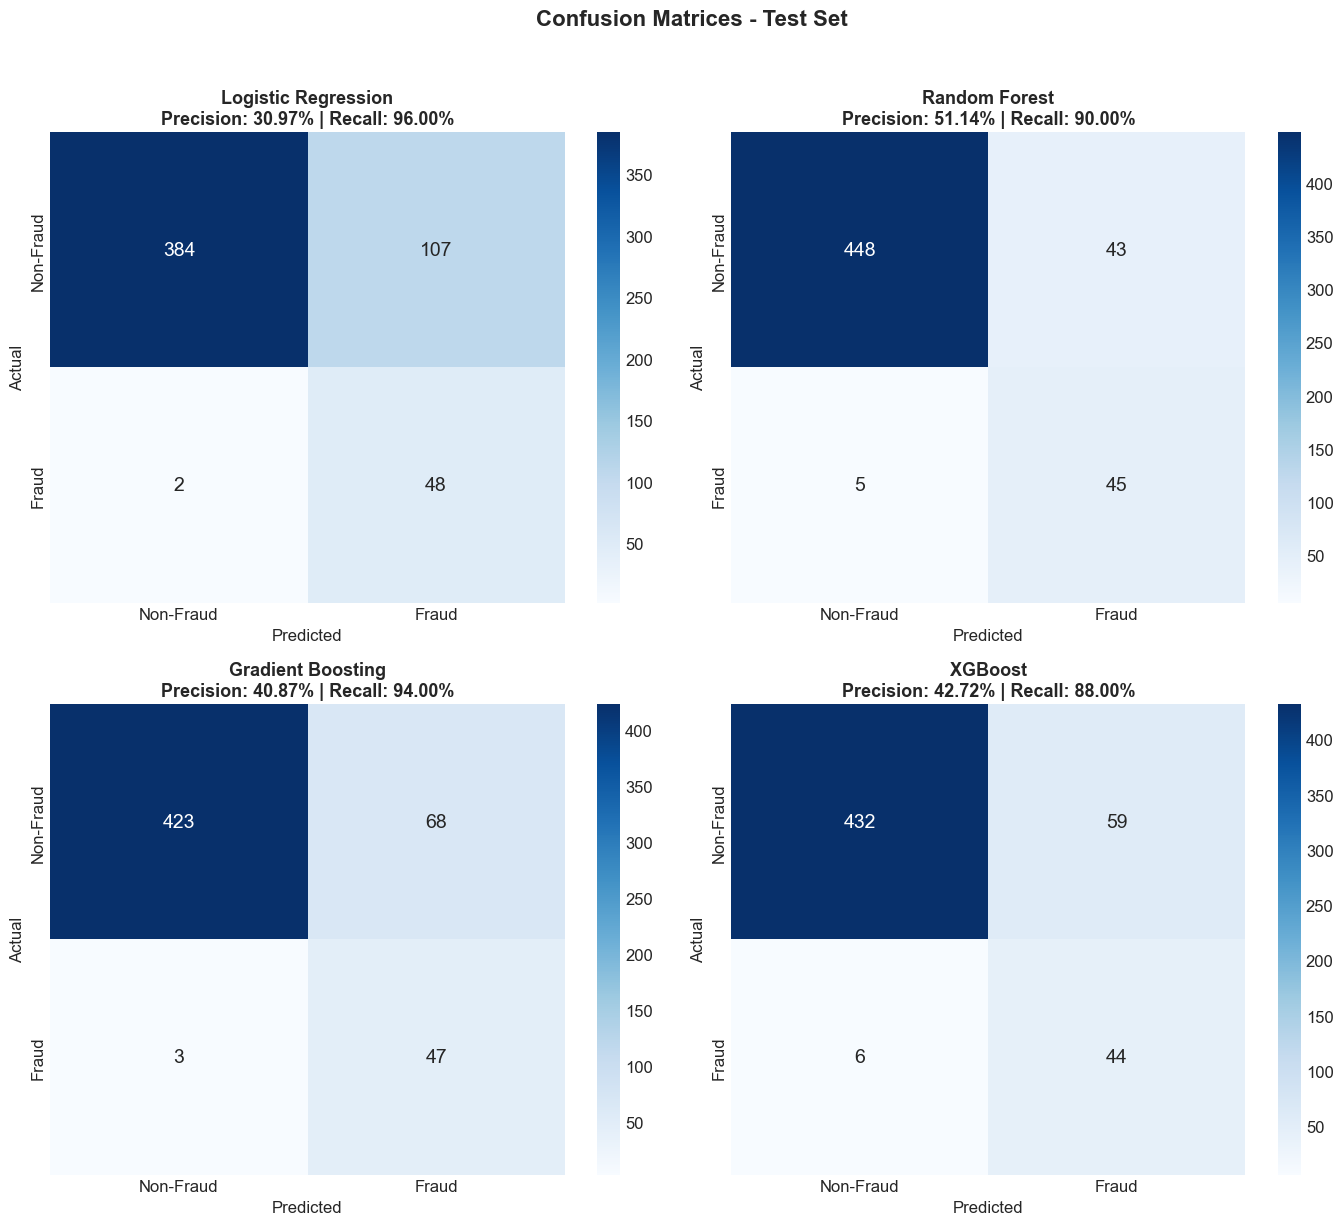

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, pred_dict) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, pred_dict['preds'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'],
                annot_kws={'size': 14})
    
    axes[idx].set_xlabel('Predicted', fontsize=12)
    axes[idx].set_ylabel('Actual', fontsize=12)
    
    prec = precision_score(y_test, pred_dict['preds'])
    rec = recall_score(y_test, pred_dict['preds'])
    axes[idx].set_title(f'{name}\nPrecision: {prec:.2%} | Recall: {rec:.2%}', 
                        fontsize=13, fontweight='bold')

plt.suptitle('Confusion Matrices - Test Set', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../reports/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Feature Importance (Random Forest)

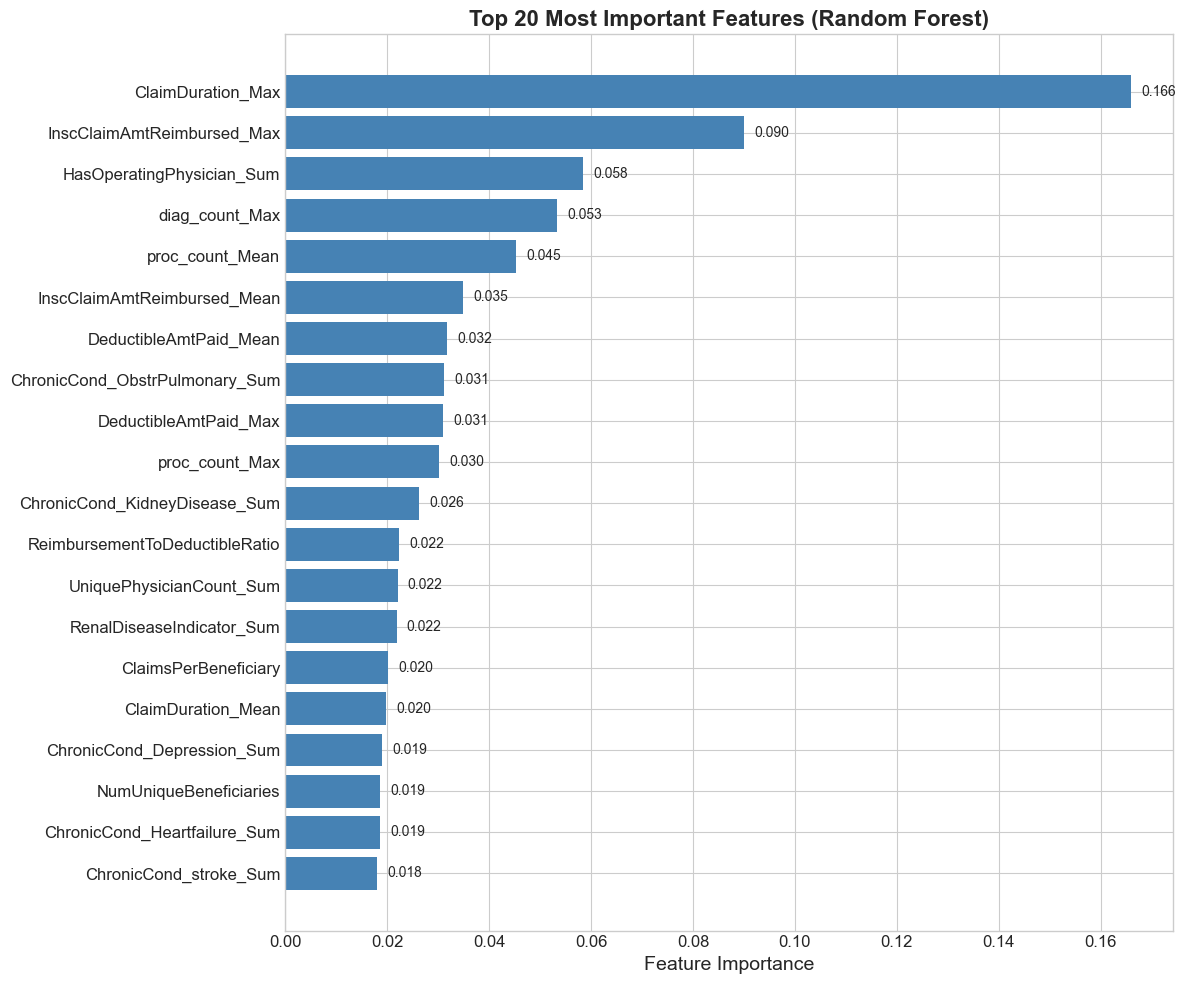


Top 10 Features:
                       feature  importance
             ClaimDuration_Max    0.165897
    InscClaimAmtReimbursed_Max    0.089944
     HasOperatingPhysician_Sum    0.058377
                diag_count_Max    0.053287
               proc_count_Mean    0.045231
   InscClaimAmtReimbursed_Mean    0.034956
        DeductibleAmtPaid_Mean    0.031751
ChronicCond_ObstrPulmonary_Sum    0.031125
         DeductibleAmtPaid_Max    0.030943
                proc_count_Max    0.030221


In [23]:
# Get feature importance from Random Forest
rf_model = models['Random Forest']

# Access the base estimator (the calibrated model wraps the original)
if hasattr(rf_model, 'estimator'):
    base_rf = rf_model.estimator
elif hasattr(rf_model, 'calibrated_classifiers_'):
    base_rf = rf_model.calibrated_classifiers_[0].estimator
else:
    base_rf = rf_model

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': base_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
fig, ax = plt.subplots(figsize=(12, 10))
top_n = 20
top_features = feature_importance.head(top_n)

bars = ax.barh(range(top_n), top_features['importance'], color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Feature Importance', fontsize=14)
ax.set_title(f'Top {top_n} Most Important Features (Random Forest)', fontsize=16, fontweight='bold')

# Add value labels
for i, (idx, row) in enumerate(top_features.iterrows()):
    ax.text(row['importance'] + 0.002, i, f'{row["importance"]:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../reports/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 Features:")
print(feature_importance.head(10).to_string(index=False))

## 6. Model Comparison Summary

In [24]:
results = []

for name, pred_dict in predictions.items():
    probs = pred_dict['probs']
    preds = pred_dict['preds']
    
    results.append({
        'Model': name,
        'Threshold': pred_dict['threshold'],
        'Precision': precision_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'F1-Score': f1_score(y_test, preds),
        'ROC AUC': roc_auc_score(y_test, probs),
        'Avg Precision': average_precision_score(y_test, probs)
    })

comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.round(4)

# Style the dataframe
print("=" * 90)
print("MODEL COMPARISON - TEST SET RESULTS")
print("=" * 90)
print(comparison_df.to_string(index=False))
print("=" * 90)

# Find best model for each metric
print("\n🏆 Best Model by Metric:")
for col in ['Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Avg Precision']:
    best_idx = comparison_df[col].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_val = comparison_df.loc[best_idx, col]
    print(f"  {col}: {best_model} ({best_val:.4f})")

# Save comparison
comparison_df.to_csv('../reports/model_comparison.csv', index=False)

MODEL COMPARISON - TEST SET RESULTS
              Model  Threshold  Precision  Recall  F1-Score  ROC AUC  Avg Precision
Logistic Regression     0.3382     0.3097    0.96    0.4683   0.9673         0.7895
      Random Forest     0.2014     0.5114    0.90    0.6522   0.9722         0.8370
  Gradient Boosting     0.4757     0.4087    0.94    0.5697   0.9717         0.8321
            XGBoost     0.5218     0.4272    0.88    0.5752   0.9725         0.8515

🏆 Best Model by Metric:
  Precision: Random Forest (0.5114)
  Recall: Logistic Regression (0.9600)
  F1-Score: Random Forest (0.6522)
  ROC AUC: XGBoost (0.9725)
  Avg Precision: XGBoost (0.8515)


## 7. Cost-Based Analysis

Analyzes the real-world financial implications of model predictions, considering the costs of false positives (investigating legitimate providers) vs false negatives (missing fraudulent providers).

In [28]:
# Define costs (hypothetical but realistic estimates)
COST_INVESTIGATION = 500       # Cost to investigate a flagged provider ($)
COST_MISSED_FRAUD = 50000      # Average cost of undetected fraud ($)

rf_preds = predictions['Random Forest']['preds']
cm = confusion_matrix(y_test, rf_preds)
tn, fp, fn, tp = cm.ravel()

# Calculate costs
cost_false_positives = fp * COST_INVESTIGATION  # Investigating legitimate providers
cost_false_negatives = fn * COST_MISSED_FRAUD   # Missing fraud
cost_true_positives = tp * COST_INVESTIGATION   # Investigating actual fraud (worth it)
total_cost = cost_false_positives + cost_false_negatives

# Baseline cost (no model - investigate everyone or no one)
cost_investigate_all = len(y_test) * COST_INVESTIGATION
cost_investigate_none = y_test.sum() * COST_MISSED_FRAUD

print("=" * 70)
print("COST-BASED ANALYSIS (Random Forest)")
print("=" * 70)
print(f"\nAssumptions:")
print(f"  - Cost to investigate a provider: ${COST_INVESTIGATION:,}")
print(f"  - Average cost of missed fraud: ${COST_MISSED_FRAUD:,}")

print(f"\nConfusion Matrix Breakdown:")
print(f"  - True Positives (fraud caught): {tp}")
print(f"  - True Negatives (legitimate cleared): {tn}")
print(f"  - False Positives (wasted investigations): {fp}")
print(f"  - False Negatives (missed fraud): {fn}")

print(f"\nCost Analysis:")
print(f"  - Cost of false positives (wasted investigations): ${cost_false_positives:,}")
print(f"  - Cost of false negatives (missed fraud): ${cost_false_negatives:,}")
print(f"  - Total model cost: ${total_cost:,}")

print(f"\nBaseline Comparisons:")
print(f"  - Cost if investigate ALL providers: ${cost_investigate_all:,}")
print(f"  - Cost if investigate NONE (miss all fraud): ${cost_investigate_none:,}")
print(f"  - Model savings vs investigate all: ${cost_investigate_all - total_cost:,} ({100*(cost_investigate_all - total_cost)/cost_investigate_all:.1f}%)")
print(f"  - Model savings vs investigate none: ${cost_investigate_none - total_cost:,} ({100*(cost_investigate_none - total_cost)/cost_investigate_none:.1f}%)")

# Cost-sensitive threshold optimization
print("\n" + "=" * 70)
print("THRESHOLD OPTIMIZATION FOR COST")
print("=" * 70)

best_cost = float('inf')
best_thresh_cost = 0
rf_probs = predictions['Random Forest']['probs']

for t in np.linspace(0.05, 0.95, 50):
    preds_t = (rf_probs >= t).astype(int)
    cm_t = confusion_matrix(y_test, preds_t)
    tn_t, fp_t, fn_t, tp_t = cm_t.ravel()
    cost_t = fp_t * COST_INVESTIGATION + fn_t * COST_MISSED_FRAUD
    if cost_t < best_cost:
        best_cost = cost_t
        best_thresh_cost = t

print(f"Current threshold ({predictions['Random Forest']['threshold']:.3f}) total cost: ${total_cost:,}")
print(f"Optimal cost threshold ({best_thresh_cost:.3f}) total cost: ${best_cost:,}")
print(f"Potential additional savings: ${total_cost - best_cost:,}")

COST-BASED ANALYSIS (Random Forest)

Assumptions:
  - Cost to investigate a provider: $500
  - Average cost of missed fraud: $50,000

Confusion Matrix Breakdown:
  - True Positives (fraud caught): 45
  - True Negatives (legitimate cleared): 448
  - False Positives (wasted investigations): 43
  - False Negatives (missed fraud): 5

Cost Analysis:
  - Cost of false positives (wasted investigations): $21,500
  - Cost of false negatives (missed fraud): $250,000
  - Total model cost: $271,500

Baseline Comparisons:
  - Cost if investigate ALL providers: $270,500
  - Cost if investigate NONE (miss all fraud): $2,500,000
  - Model savings vs investigate all: $-1,000 (-0.4%)
  - Model savings vs investigate none: $2,228,500 (89.1%)

THRESHOLD OPTIMIZATION FOR COST
Current threshold (0.201) total cost: $271,500
Optimal cost threshold (0.123) total cost: $178,500
Potential additional savings: $93,000


## 8. Error Analysis - Case Studies

Detailed analysis of model errors to understand limitations. Examines specific false positives (legitimate providers flagged as fraud) and false negatives (fraudulent providers missed).

In [29]:
# Get the original data with Provider IDs for analysis
df_full = pd.read_csv("../data/processed/train_final.csv")
X_full = df_full.drop(columns=["PotentialFraud", "Provider"])
y_full = df_full["PotentialFraud"].astype(int)
providers_full = df_full["Provider"]

# Recreate the same split to get test set providers
_, X_temp_full, _, y_temp_full = train_test_split(
    X_full, y_full, test_size=0.20, stratify=y_full, random_state=42
)
_, X_test_full, _, y_test_full = train_test_split(
    X_temp_full, y_temp_full, test_size=0.50, stratify=y_temp_full, random_state=42
)

# Get corresponding provider IDs
_, providers_temp = train_test_split(
    providers_full, test_size=0.20, stratify=y_full, random_state=42
)
_, providers_test = train_test_split(
    providers_temp, test_size=0.50, stratify=y_temp_full, random_state=42
)

# Create analysis dataframe
rf_probs = predictions['Random Forest']['probs']
rf_preds = predictions['Random Forest']['preds']

error_df = pd.DataFrame({
    'Provider': providers_test.values,
    'Actual': y_test.values,
    'Predicted': rf_preds,
    'Probability': rf_probs
})

# Add key features for analysis
key_features = ['ClaimDuration_Max', 'InscClaimAmtReimbursed_Max', 'HasOperatingPhysician_Sum', 
                'diag_count_Max', 'proc_count_Mean', 'NumUniqueBeneficiaries']
for feat in key_features:
    if feat in X_test.columns:
        error_df[feat] = X_test[feat].values

# Identify errors
false_positives = error_df[(error_df['Actual'] == 0) & (error_df['Predicted'] == 1)]
false_negatives = error_df[(error_df['Actual'] == 1) & (error_df['Predicted'] == 0)]

print("=" * 80)
print("ERROR ANALYSIS - CASE STUDIES")
print("=" * 80)

ERROR ANALYSIS - CASE STUDIES


In [30]:
# ============ FALSE POSITIVES CASE STUDIES ============
print("\n" + "=" * 80)
print("FALSE POSITIVES: Legitimate Providers Incorrectly Flagged as Fraud")
print("=" * 80)
print(f"Total False Positives: {len(false_positives)}")

# Select 3 case studies (highest probability FPs - most confident errors)
fp_cases = false_positives.nlargest(3, 'Probability')

for i, (idx, row) in enumerate(fp_cases.iterrows(), 1):
    print(f"\n{'─'*60}")
    print(f"📋 Case Study FP-{i}: Provider {row['Provider']}")
    print(f"{'─'*60}")
    print(f"  Fraud Probability: {row['Probability']:.2%} (above threshold)")
    print(f"  Actual Status: LEGITIMATE (Non-Fraud)")
    print(f"  Model Prediction: FRAUD (Incorrect)")
    print(f"\n  Key Features Contributing to Error:")
    for feat in key_features:
        if feat in row:
            # Compare to mean of legitimate providers
            legit_mean = error_df[error_df['Actual'] == 0][feat].mean()
            fraud_mean = error_df[error_df['Actual'] == 1][feat].mean()
            val = row[feat]
            if val > legit_mean:
                indicator = "↑ HIGH" if val > fraud_mean * 0.8 else "↗ elevated"
            else:
                indicator = "normal"
            print(f"    - {feat}: {val:.2f} ({indicator})")
    
    print(f"\n  📊 Why this error occurred:")
    print(f"     This provider has metrics similar to fraudulent patterns")
    print(f"     but is actually legitimate (possibly high-volume specialty)")

# Pattern analysis for FPs
print("\n" + "=" * 60)
print("FALSE POSITIVE PATTERN ANALYSIS")
print("=" * 60)
print(f"Mean fraud probability of FPs: {false_positives['Probability'].mean():.2%}")
print(f"\nCommon characteristics of false positives:")
for feat in key_features:
    if feat in false_positives.columns:
        fp_mean = false_positives[feat].mean()
        legit_mean = error_df[error_df['Actual'] == 0][feat].mean()
        pct_diff = 100 * (fp_mean - legit_mean) / legit_mean if legit_mean != 0 else 0
        print(f"  - {feat}: {fp_mean:.2f} ({pct_diff:+.1f}% vs typical legitimate)")


FALSE POSITIVES: Legitimate Providers Incorrectly Flagged as Fraud
Total False Positives: 43

────────────────────────────────────────────────────────────
📋 Case Study FP-1: Provider PRV55023
────────────────────────────────────────────────────────────
  Fraud Probability: 83.73% (above threshold)
  Actual Status: LEGITIMATE (Non-Fraud)
  Model Prediction: FRAUD (Incorrect)

  Key Features Contributing to Error:
    - ClaimDuration_Max: 35.00 (↑ HIGH)
    - InscClaimAmtReimbursed_Max: 57000.00 (↑ HIGH)
    - HasOperatingPhysician_Sum: 30.00 (↗ elevated)
    - diag_count_Max: 10.00 (↑ HIGH)
    - proc_count_Mean: 0.36 (↑ HIGH)
    - NumUniqueBeneficiaries: 52.00 (normal)

  📊 Why this error occurred:
     This provider has metrics similar to fraudulent patterns
     but is actually legitimate (possibly high-volume specialty)

────────────────────────────────────────────────────────────
📋 Case Study FP-2: Provider PRV55443
────────────────────────────────────────────────────────────
  F

In [31]:
# ============ FALSE NEGATIVES CASE STUDIES ============
print("\n" + "=" * 80)
print("FALSE NEGATIVES: Fraudulent Providers That Were Missed")
print("=" * 80)
print(f"Total False Negatives: {len(false_negatives)}")

# Select 3 case studies (lowest probability FNs - hardest to detect)
fn_cases = false_negatives.nsmallest(3, 'Probability')

for i, (idx, row) in enumerate(fn_cases.iterrows(), 1):
    print(f"\n{'─'*60}")
    print(f"🚨 Case Study FN-{i}: Provider {row['Provider']}")
    print(f"{'─'*60}")
    print(f"  Fraud Probability: {row['Probability']:.2%} (below threshold)")
    print(f"  Actual Status: FRAUDULENT")
    print(f"  Model Prediction: NON-FRAUD (Missed)")
    print(f"\n  Key Features (why model missed this):")
    for feat in key_features:
        if feat in row:
            fraud_mean = error_df[error_df['Actual'] == 1][feat].mean()
            legit_mean = error_df[error_df['Actual'] == 0][feat].mean()
            val = row[feat]
            if val < fraud_mean:
                indicator = "↓ LOW for fraud" if val < legit_mean else "→ moderate"
            else:
                indicator = "typical fraud"
            print(f"    - {feat}: {val:.2f} ({indicator})")
    
    print(f"\n  📊 Why this fraudster was missed:")
    print(f"     This provider has metrics similar to legitimate providers")
    print(f"     Possibly sophisticated fraud or small-scale operation")

# Pattern analysis for FNs
print("\n" + "=" * 60)
print("FALSE NEGATIVE PATTERN ANALYSIS")
print("=" * 60)
print(f"Mean fraud probability of FNs: {false_negatives['Probability'].mean():.2%}")
print(f"\nCommon characteristics of missed fraudsters:")
for feat in key_features:
    if feat in false_negatives.columns:
        fn_mean = false_negatives[feat].mean()
        fraud_mean = error_df[error_df['Actual'] == 1][feat].mean()
        pct_diff = 100 * (fn_mean - fraud_mean) / fraud_mean if fraud_mean != 0 else 0
        print(f"  - {feat}: {fn_mean:.2f} ({pct_diff:+.1f}% vs typical fraud)")


FALSE NEGATIVES: Fraudulent Providers That Were Missed
Total False Negatives: 5

────────────────────────────────────────────────────────────
🚨 Case Study FN-1: Provider PRV56566
────────────────────────────────────────────────────────────
  Fraud Probability: 2.31% (below threshold)
  Actual Status: FRAUDULENT
  Model Prediction: NON-FRAUD (Missed)

  Key Features (why model missed this):
    - ClaimDuration_Max: 20.00 (→ moderate)
    - InscClaimAmtReimbursed_Max: 12000.00 (→ moderate)
    - HasOperatingPhysician_Sum: 29.00 (→ moderate)
    - diag_count_Max: 9.00 (→ moderate)
    - proc_count_Mean: 0.01 (↓ LOW for fraud)
    - NumUniqueBeneficiaries: 63.00 (→ moderate)

  📊 Why this fraudster was missed:
     This provider has metrics similar to legitimate providers
     Possibly sophisticated fraud or small-scale operation

────────────────────────────────────────────────────────────
🚨 Case Study FN-2: Provider PRV56023
────────────────────────────────────────────────────────────
 

In [32]:
# ============ RECOMMENDATIONS FOR IMPROVEMENT ============
print("\n" + "=" * 80)
print("RECOMMENDATIONS FOR MODEL IMPROVEMENT")
print("=" * 80)

print("""
┌─────────────────────────────────────────────────────────────────────────────┐
│ 1. FALSE POSITIVE MITIGATION (Reduce wasted investigations)                │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Add provider tenure/history features (new providers may look suspicious) │
│  • Include specialty-adjusted benchmarks (high-volume specialties differ)  │
│  • Add peer comparison features (compare to similar-sized providers)       │
│  • Implement claim approval rate trends over time                          │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│ 2. FALSE NEGATIVE MITIGATION (Catch more fraud)                            │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Add network analysis features (connections between providers/patients)   │
│  • Include temporal patterns (sudden changes in billing behavior)          │
│  • Add beneficiary-level anomaly scores aggregated to provider             │
│  • Detect "slow and steady" fraud with trend-based features                │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│ 3. THRESHOLD & MODEL ADJUSTMENTS                                           │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Use cost-sensitive threshold based on investigation capacity            │
│  • Consider different thresholds for different provider types              │
│  • Implement two-stage screening (coarse then fine-grained)                │
│  • Ensemble multiple models with voting/stacking                           │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│ 4. DATA & FEATURE ENHANCEMENTS                                             │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Collect more labeled data for rare fraud patterns                       │
│  • Add external data (license status, malpractice history)                 │
│  • Engineer interaction features between key variables                     │
│  • Use SMOTE or other oversampling for minority class                      │
└─────────────────────────────────────────────────────────────────────────────┘
""")

# Save error analysis to CSV
error_df.to_csv('../reports/error_analysis.csv', index=False)
print("✅ Error analysis saved to ../reports/error_analysis.csv")


RECOMMENDATIONS FOR MODEL IMPROVEMENT

┌─────────────────────────────────────────────────────────────────────────────┐
│ 1. FALSE POSITIVE MITIGATION (Reduce wasted investigations)                │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Add provider tenure/history features (new providers may look suspicious) │
│  • Include specialty-adjusted benchmarks (high-volume specialties differ)  │
│  • Add peer comparison features (compare to similar-sized providers)       │
│  • Implement claim approval rate trends over time                          │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│ 2. FALSE NEGATIVE MITIGATION (Catch more fraud)                            │
├─────────────────────────────────────────────────────────────────────────────┤
│  • Add network analysis features (connections between providers/patients)   │
│  •

In [33]:
# Classification Report for Best Model
print("\n" + "=" * 60)
print("DETAILED CLASSIFICATION REPORT - Random Forest (Final Model)")
print("=" * 60)

rf_preds = predictions['Random Forest']['preds']
print(classification_report(y_test, rf_preds, target_names=['Non-Fraud', 'Fraud']))


DETAILED CLASSIFICATION REPORT - Random Forest (Final Model)
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.91      0.95       491
       Fraud       0.51      0.90      0.65        50

    accuracy                           0.91       541
   macro avg       0.75      0.91      0.80       541
weighted avg       0.94      0.91      0.92       541



## 9. Summary & Conclusions

In [34]:
print("=" * 70)
print("FRAUD DETECTION MODEL EVALUATION SUMMARY")
print("=" * 70)

rf_probs = predictions['Random Forest']['probs']
rf_preds = predictions['Random Forest']['preds']

print(f"""
Dataset Statistics:
  - Training samples: {len(y_train):,}
  - Validation samples: {len(y_val):,}
  - Test samples: {len(y_test):,}
  - Fraud rate (test): {y_test.mean():.2%}

Final Model: Random Forest (Calibrated)
  - Threshold: {predictions['Random Forest']['threshold']:.4f}
  - Precision: {precision_score(y_test, rf_preds):.2%}
  - Recall: {recall_score(y_test, rf_preds):.2%}
  - F1-Score: {f1_score(y_test, rf_preds):.2%}
  - ROC AUC: {roc_auc_score(y_test, rf_probs):.4f}
  - Average Precision: {average_precision_score(y_test, rf_probs):.4f}

Key Insights:
  - Random Forest selected for best balance of precision and recall
  - Threshold tuned to achieve high recall (catching most fraud)
  - Calibration applied for reliable probability estimates
""")
print("=" * 70)

FRAUD DETECTION MODEL EVALUATION SUMMARY

Dataset Statistics:
  - Training samples: 4,328
  - Validation samples: 541
  - Test samples: 541
  - Fraud rate (test): 9.24%

Final Model: Random Forest (Calibrated)
  - Threshold: 0.2014
  - Precision: 51.14%
  - Recall: 90.00%
  - F1-Score: 65.22%
  - ROC AUC: 0.9722
  - Average Precision: 0.8370

Key Insights:
  - Random Forest selected for best balance of precision and recall
  - Threshold tuned to achieve high recall (catching most fraud)
  - Calibration applied for reliable probability estimates

